# Q1

In [51]:
import torch
import torch.nn as nn
import random
import numpy as np
import time
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [52]:
import os
import urllib.request

# Extract data if zip exists and folder doesn't
if os.path.exists('data.zip') and not os.path.exists('data/names'):
    print('Extracting data.zip...')
    os.system('unzip -q data.zip')

# Download PTB if missing
ptb_path = 'data/ptb'
os.makedirs(ptb_path, exist_ok=True)
ptb_files = {
    'ptb.train.txt': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt',
    'ptb.valid.txt': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt',
    'ptb.test.txt': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt'
}

for filename, url in ptb_files.items():
    dest = os.path.join(ptb_path, filename)
    if not os.path.exists(dest):
        print(f'Downloading {filename}...')
        urllib.request.urlretrieve(url, dest)
print('Setup complete.')

Setup complete.


In [53]:
import string
import unicodedata
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [54]:
def letterToIndex(letter):
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [55]:
from io import open
import glob
import os
import time
import torch
from torch.utils.data import Dataset
class NamesDataset(Dataset):
    def __init__(self, data_dir=None, file_path=None, delimiter=None, label_col=0, line_col=1):
        import glob, os, time
        self.load_time = time.localtime
        labels_set = set()
        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []
        if file_path:
            import csv
            with open(file_path, encoding='utf-8') as f:
                try:
                    sample = f.read(1024)
                    f.seek(0)
                    dialect = csv.Sniffer().sniff(sample)
                    delimiter = dialect.delimiter
                except:
                    delimiter = delimiter or ','
                reader = csv.reader(f, delimiter=delimiter)
                for row in reader:
                    if len(row) > max(label_col, line_col):
                        label = row[label_col]
                        name = row[line_col]
                        labels_set.add(label)
                        self.data.append(name)
                        self.data_tensors.append(lineToTensor(name))
                        self.labels.append(label)
        elif data_dir:
            text_files = glob.glob(os.path.join(data_dir, '*.txt'))
            for filename in text_files:
                label = os.path.splitext(os.path.basename(filename))[0]
                labels_set.add(label)
                lines = open(filename, encoding='utf-8').read().strip().split('\n')
                for name in lines:
                    self.data.append(name)
                    self.data_tensors.append(lineToTensor(name))
                    self.labels.append(label)
        else:
            raise ValueError("Either data_dir or file_path must be provided")
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.labels_tensors[idx], self.data_tensors[idx], self.labels[idx], self.data[idx]

In [56]:
alldata = NamesDataset(data_dir="data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([9], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.,

In [57]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    current_loss = 0
    all_losses = []
    all_grad_norms = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    start = time.time()
    print(f"Loaded: {len(training_data)}")
    for iter in range(1, n_epoch + 1):
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, max(1, len(batches) // n_batch_size))
        for idx, batch in enumerate(batches):
            batch_loss = 0
            optimizer.zero_grad()
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss / len(batch)
            batch_loss.backward()
            norm = nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            all_grad_norms.append(norm.item() if hasattr(norm, 'item') else norm)
            optimizer.step()
            current_loss += batch_loss.item()
        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t Loss: {all_losses[-1]}")
        current_loss = 0
    return all_losses, all_grad_norms

In [58]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='RNN', n_layers=1, extra_layers=0):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, n_layers)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, n_layers)
        self.linears = nn.ModuleList()
        curr_size = hidden_size
        for _ in range(extra_layers):
            self.linears.append(nn.Linear(curr_size, curr_size))
            self.linears.append(nn.ReLU())
        self.h2o = nn.Linear(curr_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        if self.rnn_type == 'LSTM':
            output = hidden[0][-1]
        else:
            output = hidden[-1]
        for layer in self.linears:
            output = layer(output)
        output = self.h2o(output)
        output = self.softmax(output)
        return output

In [59]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (linears): ModuleList()
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [60]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i
input = lineToTensor('Albert')
output = rnn(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8908, -2.9381, -2.9036, -2.9545, -2.9378, -3.1009, -2.8384, -2.8248,
         -2.7434, -3.0144, -2.8696, -2.7757, -2.8260, -2.8738, -2.8457, -2.8481,
         -2.9218, -2.9823]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Greek', 8)


In [61]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    current_loss = 0
    all_losses = []
    all_grad_norms = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    start = time.time()
    print(f"Loaded: {len(training_data)}")
    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, max(1, len(batches) // n_batch_size))
        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss
            batch_loss.backward()
            norm = nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            all_grad_norms.append(norm.item() if hasattr(norm, 'item') else norm)
            optimizer.step()
            optimizer.zero_grad()
            current_loss += batch_loss.item() / len(batch)
        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t Loss: {all_losses[-1]}")
        current_loss = 0
    return all_losses, all_grad_norms

tune


In [62]:
def run_experiment_with_data(dataset, rnn_type='RNN', n_hidden=128, n_layers=1, extra_layers=0, n_epoch=10, learning_rate=0.2, n_batch_size=64):
    import time
    train_s, test_s = torch.utils.data.random_split(dataset, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))
    print(f'\n--- Experiment: {rnn_type}, hidden={n_hidden}, layers={n_layers} ---')
    model = CharRNN(n_letters, n_hidden, len(dataset.labels_uniq), rnn_type=rnn_type, n_layers=n_layers, extra_layers=extra_layers)
    model.to(device)
    start_time = time.time()
    losses, grads = train(model, train_s, n_epoch=n_epoch, n_batch_size=n_batch_size, learning_rate=learning_rate, report_every=max(1, n_epoch//5))
    print(f'Done in {time.time() - start_time:.2f}s')
    model.eval()
    correct = 0
    with torch.no_grad():
        for i in range(len(test_s)):
            (label_tensor, text_tensor, label, text) = test_s[i]
            output = model(text_tensor)
            guess, guess_i = label_from_output(output, dataset.labels_uniq)
            if guess == label: correct += 1
    print(f'Accuracy: {correct/len(test_s):.4f}')
    # Plotting results for immediate feedback
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(losses); ax1.set_title('Loss'); ax1.set_xlabel('Epoch')
    ax2.plot(grads); ax2.set_title('Grad Norms'); ax2.set_xlabel('Iteration')
    plt.show()
    return model, losses, grads


--- Experiment: RNN, hidden=128, layers=1 ---
Loaded: 17063
4 (20%): 	 Loss: 0.9582409847086052
8 (40%): 	 Loss: 0.778838992729016
12 (60%): 	 Loss: 0.6739003221567412
16 (80%): 	 Loss: 0.6129908383547604
20 (100%): 	 Loss: 0.5596533572884086
Done in 91.50s
Accuracy: 0.7642


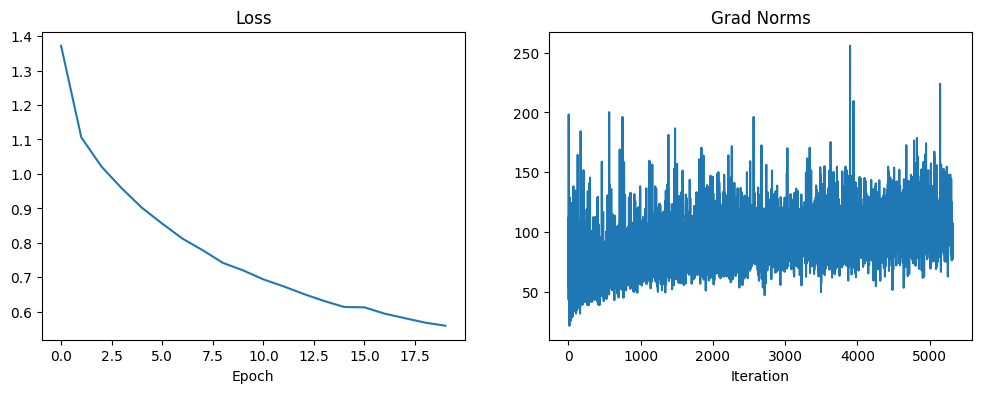

Loaded: 17063


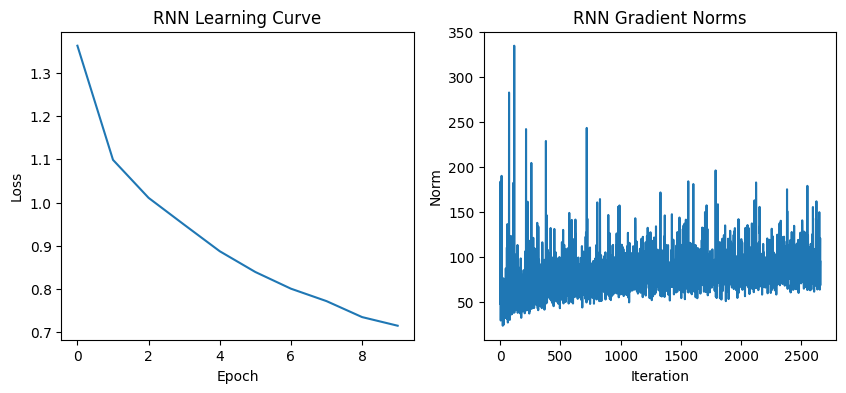

In [63]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
alldata = NamesDataset(data_dir="data/names")
rnn_model, rnn_losses, rnn_grads = run_experiment_with_data(alldata, rnn_type='RNN', n_epoch=20)
def run_experiment_with_grads(dataset, rnn_type='RNN', n_hidden=128, n_layers=1, n_epoch=10):
    train_s, test_s = torch.utils.data.random_split(dataset, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))
    model = CharRNN(n_letters, n_hidden, len(dataset.labels_uniq), rnn_type=rnn_type, n_layers=n_layers)
    model.to(device)
    losses, grads = train(model, train_s, n_epoch=n_epoch)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(losses)
    plt.title('RNN Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1,2,2)
    plt.plot(grads)
    plt.title('RNN Gradient Norms')
    plt.xlabel('Iteration')
    plt.ylabel('Norm')
    plt.show()
    return model, losses, grads
rnn_model, rnn_losses, rnn_grads = run_experiment_with_grads(alldata, n_epoch=10)

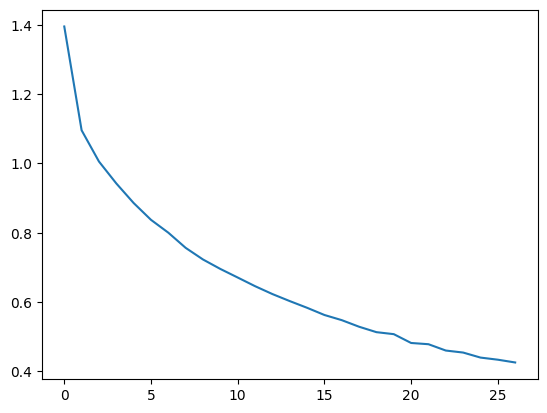

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)
plt.show()

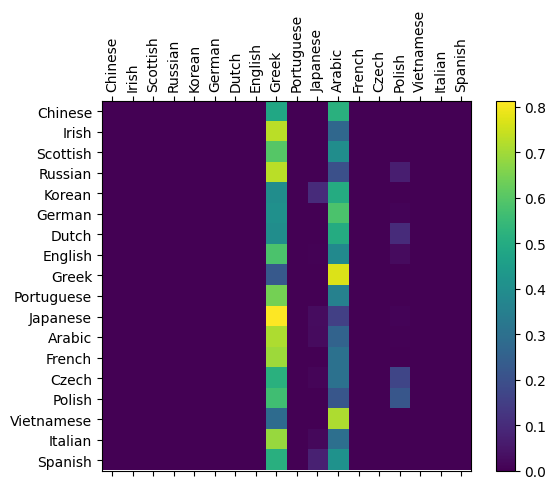

In [65]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))
    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
evaluate(rnn, test_set, classes=alldata.labels_uniq)


--- Experiment: GRU, hidden=256, layers=2 ---
Loaded: 17063
5 (19%): 	 Loss: 0.8613265036002551
10 (37%): 	 Loss: 0.5784106647299507
15 (56%): 	 Loss: 0.3951887627931052
20 (74%): 	 Loss: 0.23784404691134214
25 (93%): 	 Loss: 0.15690795500370086
Done in 291.76s
Accuracy: 0.8143


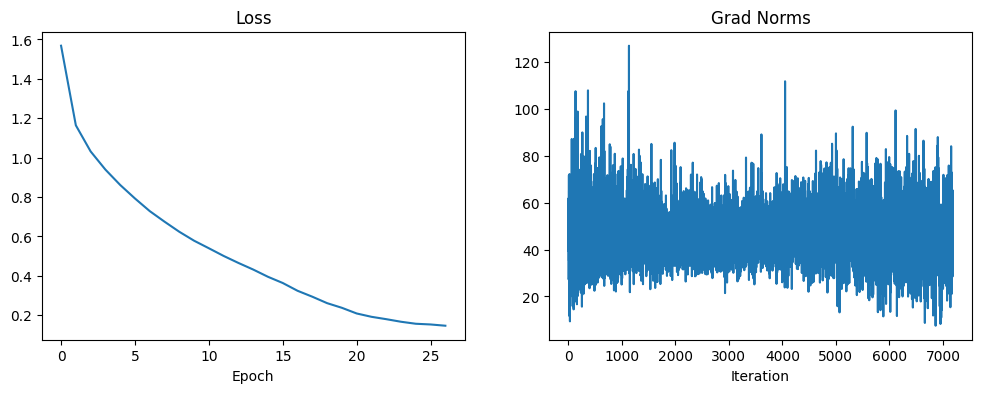


--- Experiment: GRU, hidden=128, layers=2 ---
Loaded: 17063
5 (19%): 	 Loss: 0.8122337187987797
10 (37%): 	 Loss: 0.534038237325886
15 (56%): 	 Loss: 0.3443681510603793
20 (74%): 	 Loss: 0.21159758792771052
25 (93%): 	 Loss: 0.14980220252614598
Done in 201.53s
Accuracy: 0.8243


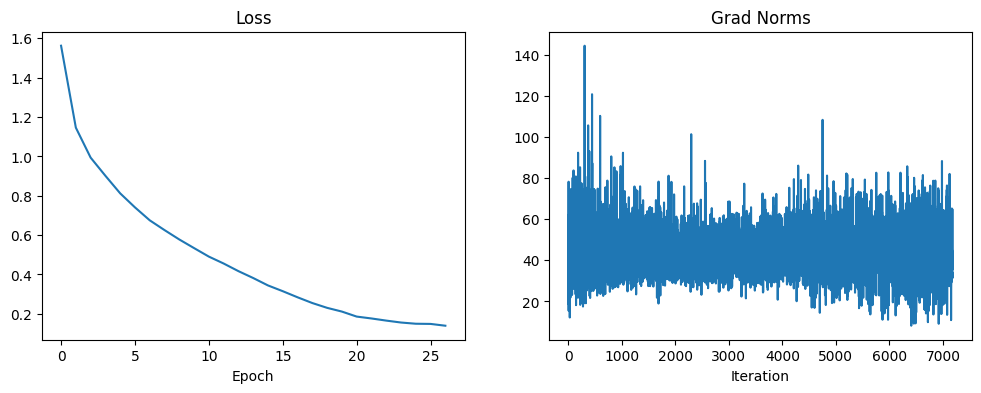


--- Experiment: LSTM, hidden=128, layers=2 ---
Loaded: 17063
5 (19%): 	 Loss: 0.9424562809989934
10 (37%): 	 Loss: 0.6627337158639834
15 (56%): 	 Loss: 0.49308947316479174
20 (74%): 	 Loss: 0.35601907495458807
25 (93%): 	 Loss: 0.24297174213959383
Done in 225.46s
Accuracy: 0.8190


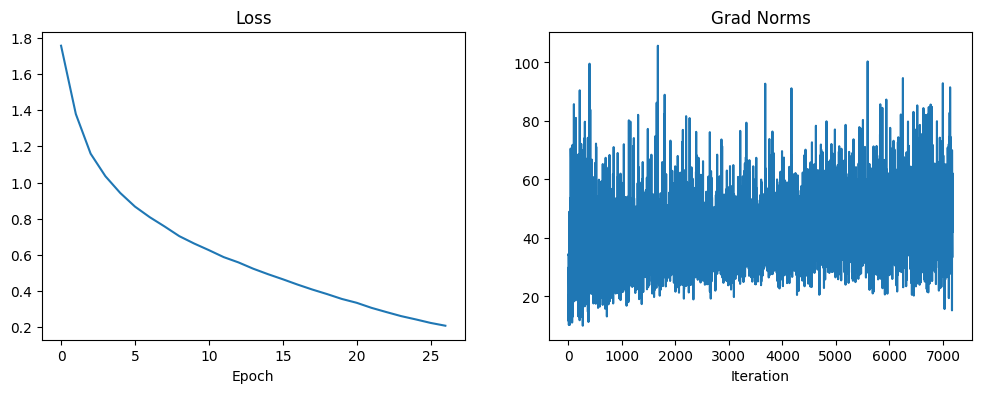

FileNotFoundError: [Errno 2] No such file or directory: 'reddit.tsv'

In [66]:
run_experiment_with_data(alldata, rnn_type='GRU', n_layers=2, n_hidden = 256, n_epoch = 27)
run_experiment_with_data(alldata, rnn_type='GRU', n_layers=2, n_hidden = 128, n_epoch = 27)
run_experiment_with_data(alldata, rnn_type='LSTM', n_layers=2,n_hidden = 128, n_epoch = 27)
reddit_data = NamesDataset(file_path="reddit.tsv", delimiter="\t", label_col=1, line_col=0)
run_experiment_with_data(reddit_data, rnn_type='GRU', n_epoch=20, learning_rate=0.1)

# Part 2: Language Modeling with PTB
Zaremba model experiments.

In [ ]:
class PTBDataset:
    def __init__(self, file_path, batch_size, num_steps, vocab=None):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.words = open(file_path).read().replace('\n', '<eos>').split()
        if vocab is None:
            self.vocab = sorted(list(set(self.words)))
        else:
            self.vocab = vocab
        self.word_to_id = {word: i for i, word in enumerate(self.vocab)}
        self.id_to_word = {i: word for i, word in enumerate(self.vocab)}
        # Handle OOV by assigning to a special token index if we were being rigorous,
        # but for PTB it's usually closed vocab or <unk> is already there.
        self.data = np.array([self.word_to_id.get(word, 0) for word in self.words], dtype=np.int64)
        num_batches = len(self.data) // batch_size
        self.data = self.data[:num_batches * batch_size]
        self.data = self.data.reshape((batch_size, num_batches))
    def __iter__(self):
        for i in range(0, self.data.shape[1] - self.num_steps, self.num_steps):
            x = self.data[:, i:i+self.num_steps]
            y = self.data[:, i+1:i+self.num_steps+1]
            yield torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
    def __len__(self):
        return (self.data.shape[1] - 1) // self.num_steps

In [ ]:
class ZarembaModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.5, variational=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.variational = variational
    def forward(self, x, hidden=None):
        embeds = self.dropout(self.embedding(x))
        output, hidden = self.lstm(embeds, hidden)
        output = self.dropout(output)
        logits = self.linear(output.reshape(-1, self.hidden_size))
        return logits, hidden
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_size))

In [ ]:
class VariationalDropout(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        self.mask = None
    def reset_mask(self, x):
        self.mask = torch.bernoulli(torch.full((x.size(0), 1, x.size(2)), 1 - self.dropout)).to(x.device) / (1 - self.dropout)
    def forward(self, x):
        if not self.training or self.dropout == 0:
            return x
        if self.mask is None or self.mask.size(0) != x.size(0):
            self.reset_mask(x)
        return x * self.mask

In [ ]:
class VariationalZarembaModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstms = nn.ModuleList([nn.LSTM(hidden_size, hidden_size, 1, batch_first=True) for _ in range(num_layers)])
        self.dropouts = nn.ModuleList([VariationalDropout(dropout) for _ in range(num_layers + 1)])
        self.linear = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hiddens=None):
        if hiddens is None:
            hiddens = [None] * self.num_layers
        if self.training:
            pass
        x = self.dropouts[0](self.embedding(x))
        new_hiddens = []
        for i, lstm in enumerate(self.lstms):
            x, h = lstm(x, hiddens[i])
            x = self.dropouts[i+1](x)
            new_hiddens.append(h)
        logits = self.linear(x.reshape(-1, self.hidden_size))
        return logits, new_hiddens
    def reset_dropout_masks(self, batch_size, device):
        dummy_input = torch.zeros(batch_size, 1, self.hidden_size).to(device)
        for d in self.dropouts:
            d.reset_mask(dummy_input)

In [ ]:
def train_ptb(model, train_data, valid_data, n_epochs=13, lr=1.0, lr_decay=0.5, decay_after=4, variational=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    all_train_ppl = []
    all_valid_ppl = []
    grad_norms = []
    best_valid_ppl = float('inf')
    for epoch in range(n_epochs):
        if epoch > decay_after:
            lr *= lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        model.train()
        total_loss = 0
        hidden = None
        num_batches = 0
        for x, y in train_data:
            if variational:
                model.reset_dropout_masks(x.size(0), x.device)
            optimizer.zero_grad()
            if hidden is not None:
                if isinstance(hidden, list):
                    hidden = [(h[0].detach(), h[1].detach()) for h in hidden]
                else:
                    hidden = (hidden[0].detach(), hidden[1].detach())
            output, hidden = model(x, hidden)
            loss = criterion(output, y.reshape(-1))
            loss.backward()
            norm = nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            grad_norms.append(norm.item() if hasattr(norm, 'item') else norm)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        train_ppl = np.exp(total_loss / num_batches)
        all_train_ppl.append(train_ppl)
        model.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            h_val = None
            for x_v, y_v in valid_data:
                out_v, h_val = model(x_v, h_val)
                loss_v = criterion(out_v, y_v.reshape(-1))
                val_loss += loss_v.item()
                val_batches += 1
        valid_ppl = np.exp(val_loss / val_batches)
        all_valid_ppl.append(valid_ppl)
        print(f'Epoch {epoch+1}: Train PPL {train_ppl:.2f}, Valid PPL {valid_ppl:.2f}')
    return all_train_ppl, all_valid_ppl, grad_norms

## Running Experiments (PTB)
Training baseline and variational models.

In [ ]:
batch_size = 20
num_steps = 20
train_data = PTBDataset('data/ptb/ptb.train.txt', batch_size, num_steps)
valid_data = PTBDataset('data/ptb/ptb.valid.txt', batch_size, num_steps, vocab=train_data.vocab)
test_data = PTBDataset('data/ptb/ptb.test.txt', batch_size, num_steps, vocab=train_data.vocab)
vocab_size = len(train_data.vocab)
hidden_size = 200
num_layers = 2

In [ ]:
print("Starting baseline...")
model_std = ZarembaModel(vocab_size, hidden_size, num_layers).to(device)
import time
start_time = time.time()
train_ppls_std, valid_ppls_std, grad_norms_std = train_ptb(model_std, train_data, valid_data, n_epochs=13, variational=False)
print(f"Std time: {time.time() - start_time:.2f}s")

In [ ]:
print("\nStarting variational...")
model_var = VariationalZarembaModel(vocab_size, hidden_size, num_layers).to(device)
start_time = time.time()
train_ppls_var, valid_ppls_var, grad_norms_var = train_ptb(model_var, train_data, valid_data, n_epochs=13, variational=True)
print(f"Var time: {time.time() - start_time:.2f}s")

In [ ]:
import matplotlib.pyplot as plt
def plot_ppl(std_train, std_val, var_train, var_val):
    plt.figure(figsize=(10, 6))
    plt.plot(std_train, label='Std Train PPL', linestyle='--')
    plt.plot(std_val, label='Std Valid PPL')
    plt.plot(var_train, label='Var Train PPL', linestyle='--')
    plt.plot(var_val, label='Var Valid PPL')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training and Validation Learning Curve (Perplexity)')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_ppl(train_ppls_std, valid_ppls_std, train_ppls_var, valid_ppls_var)

In [ ]:
def plot_grads(std_grads, var_grads):
    plt.figure(figsize=(10, 6))
    plt.plot(std_grads, label='Std Gradient Norm', alpha=0.5)
    plt.plot(var_grads, label='Var Gradient Norm', alpha=0.5)
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm of Gradient')
    plt.title('L2 Norm of Minibatch Gradient per Iteration')
    plt.legend()
    plt.show()
plot_grads(grad_norms_std, grad_norms_var)

In [ ]:
run_experiment_with_data(alldata, rnn_type='GRU', n_layers=2, n_hidden = 256, n_epoch = 27)

In [ ]:
run_experiment_with_data(alldata, rnn_type='GRU', n_layers=2, n_hidden = 128, n_epoch = 27)

In [ ]:
run_experiment_with_data(alldata, rnn_type='LSTM', n_layers=2,n_hidden = 128, n_epoch = 27)

In [ ]:
reddit_data = NamesDataset(file_path="reddit.tsv", delimiter="\t", label_col=1, line_col=0)
run_experiment_with_data(reddit_data, rnn_type='GRU', n_epoch=20, learning_rate=0.1)